# Task 1. Support Vector Machine

a) Calculate $w$ and $b$ for the support vectors. The Lagrange multipliers are already calculated.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("svm_data.csv", delimiter=";", index_col=0)
df.head()


,xi1,xi2,yi
xi,,,
x1,3.5,4.25,1.0
x2,4.0,3.00,1.0
x3,4.0,4.00,1.0
x4,4.5,1.75,1.0
x5,4.9,4.50,1.0


In [3]:
# Support vectors
svs = {

    'xi': ['x1', 'x2', 'x4', 'x13', 'x14'],
    'ai': [0.0437, 0.2162, 0.1472, 0.3589, 0.0437]
}

svs = pd.DataFrame(svs)
svs


,xi,ai
0,x1,0.0437
1,x2,0.2162
2,x4,0.1472
3,x13,0.3589
4,x14,0.0437


For linear SVM, the Lagrangian has the form
$$\mathcal{L}(w, b) = \frac{1}{2}w^T w + \sum \alpha_i(1 - y_i(w^T x_i + b))$$
Note: if $\alpha_i > 0$, then $x_i$ is a support vector and $y_i(w^T x_i + b) = 1$.
According to gradient condition:
$$\frac{\partial \mathcal{L}}{\partial w} = w - \sum{\alpha_i y_i x_i} = 0$$ 


In [4]:
w = np.zeros(2)

for i, sv in svs.iterrows():
    index, alpha = sv.iloc[0], sv.iloc[1]
    xi = df.loc[index, ['xi1', 'xi2']]
    yi = df.loc[index, 'yi']
    w += alpha * yi * xi
w = w.to_numpy()
w


array([0.8531 , 0.34135])

In [5]:
for i, sv in svs.iterrows():
    index, alpha = sv.iloc[0], sv.iloc[1]
    xi = df.loc[index, ['xi1', 'xi2']].to_numpy()
    yi = df.loc[index, 'yi']
    print(yi - w.T@xi)

b = yi - w.T@xi


-3.4365875
-3.436449999999999
-3.4363124999999988
-3.3888999999999996
-3.3887624999999995


b) Draw the coordinate system with the margins and the hyperplane.

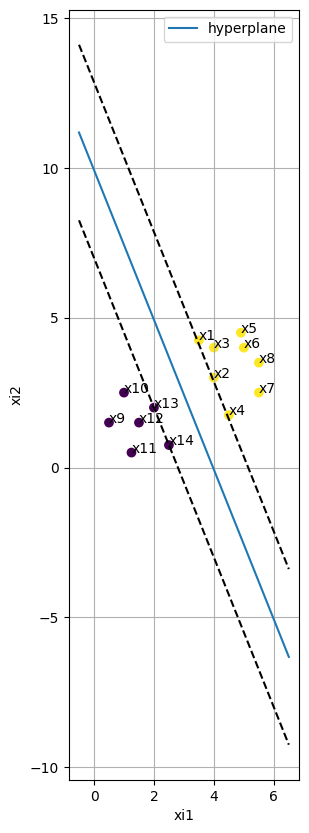

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))

# plot the original poitns
ax.scatter(df['xi1'], df['xi2'], c = df['yi'])
for i, vec in df.iterrows():
    ax.annotate(i, (vec['xi1'], vec['xi2']))

# plot the hyperplane
x = np.linspace(df['xi1'].min()-1, df['xi1'].max()+1)
y = -w[0]/w[1]*x - b/w[1]
ax.plot(x, y, label = "hyperplane")

# plot the margin to each of the class
y = y + 1/w[1]
ax.plot(x, y, linestyle = '--', c='black')
y = y - 2/w[1]
ax.plot(x, y, linestyle = '--', c='black')
ax.legend()
ax.set_xlabel("xi1")
ax.set_ylabel("xi2")
# ax.set_xlim(df['xi1'].min()-1, df['xi1'].max()+1)
ax.grid()
fig.gca().set_aspect('equal')
fig.show()


c) Which points are misclassified by the present hyperplane?

This is a hard margin SVM which does not allow misclassifications. Therefore no points are misclassified.

# Task 2
a) Generate datasets of size $100$ for the following values:

In [8]:
from generator import data_generator as data_generator

ds1 = data_generator(-0.1, 0.7, 100)
ds2 = data_generator(0.1, 2, 100)
ds3 = data_generator(0.75, -0.2, 100)
ds4 = data_generator(1, -1, 100)


In [9]:
import numpy as np
np.array(ds1).shape


(100, 3)

b) Create a class that can learn a separating hyperplane
To find the Lagrange multipliers $\alpha_i$, we find the maximum of the dual problem
$$max{\mathcal{L}(\alpha) = \sum \alpha_i - \frac{1}{2}\sum \sum \alpha_i \alpha_j y_i y_j x_i^T x_j}$$
or minimize
$$-\mathcal{L}$$

The dataset has shape $100 \times 3$, where $100$ is the number of samples, and $3 = 2+1$ is the number of features $2$ plus additional label column.

By multiplying $X_\text{data} X_\text{data}^T$, we will obtain a $100 \times 100$ matrix and similarly $Y_\text{data} Y_\text{data}^T$, then we multiply the two matrices elementwise and calculate the sum, the latter part of the Lagrangian is almost there 

In [10]:
class support_vector_machine():
    def __init__(self):
        return

    def fit(self, ds):
        self.ds = np.array(ds)
        self.X_data = self.ds[:, :-1]
        self.Y_data = self.ds[:, -1]
        self.alpha = np.random.random(len(self.Y_data))
        self.__optimize()
        self.__calculate_parameters()
        export_data = {}
        export_data['alpha'] = self.alpha
        export_data['coef_'] = self.w
        export_data['intercept_'] = self.b
        return export_data

    def __lagrangian_neg(self, alpha):
        l = alpha.sum() - 1/2 * (np.outer(alpha, alpha) * (self.X_data@self.X_data.T) * np.outer(self.Y_data,self.Y_data)).sum().sum()
        return -l

    def __optimize(self):
        from scipy.optimize import minimize, LinearConstraint
        # alpha > 0
        constraint1 = LinearConstraint(np.eye(len(self.alpha)), lb=np.zeros(len(self.alpha)))
        # (sum(Y.T * alpha = 0))
        constraint2 = LinearConstraint(self.Y_data, lb = 0, ub= 0)
        minfn = minimize(self.__lagrangian_neg, self.alpha, constraints=(constraint1, constraint2))
        self.alpha = minfn['x']

    def __calculate_parameters(self):
        self.w = np.zeros(2)
        for i in np.where(self.alpha > 1e-7)[0]:
            self.w += self.alpha[i] * self.Y_data[i] * self.X_data[i]
        self.b = self.Y_data[i] - self.w.T@self.X_data[i]


In [11]:
svm = support_vector_machine()
svm.fit(ds3)


{'alpha': array([-1.43974129e-12, -7.85514215e-13,  9.74184787e-15,  5.20784076e-15,
        -1.42496734e-14, -4.66934929e-14,  2.58378438e-14, -2.40490220e-13,
        -1.44231569e-14,  1.58767593e-14, -1.90784273e-14,  3.30185293e-16,
        -4.93362395e-14, -3.70496788e-14, -1.08531959e-14,  2.33632272e-14,
        -5.89292787e-14, -6.75060461e-12, -3.13460964e-14, -2.87006347e-14,
        -5.94737171e-15, -1.70025576e-12, -3.59469164e-14, -5.94815494e-15,
        -1.21519778e-12, -5.77685240e-13, -1.57959507e-12,  7.50507157e-15,
        -4.49044457e-14, -3.38972820e-14, -2.17759642e-15, -2.93787081e-14,
        -3.03041235e-14, -4.11501841e-14, -2.12025182e-14, -1.62917266e-13,
         1.83142438e-14,  8.80614089e-15,  1.96326219e-14, -4.05273391e-13,
         1.96585377e-14, -1.41873349e-14, -6.02310369e-15,  2.53416856e-14,
        -1.80641761e-14, -1.59915905e-13, -4.88094352e-13, -1.36830523e-13,
        -5.21361437e-13,  2.47080606e-14, -3.92859428e-13,  2.33822706e-14,
   

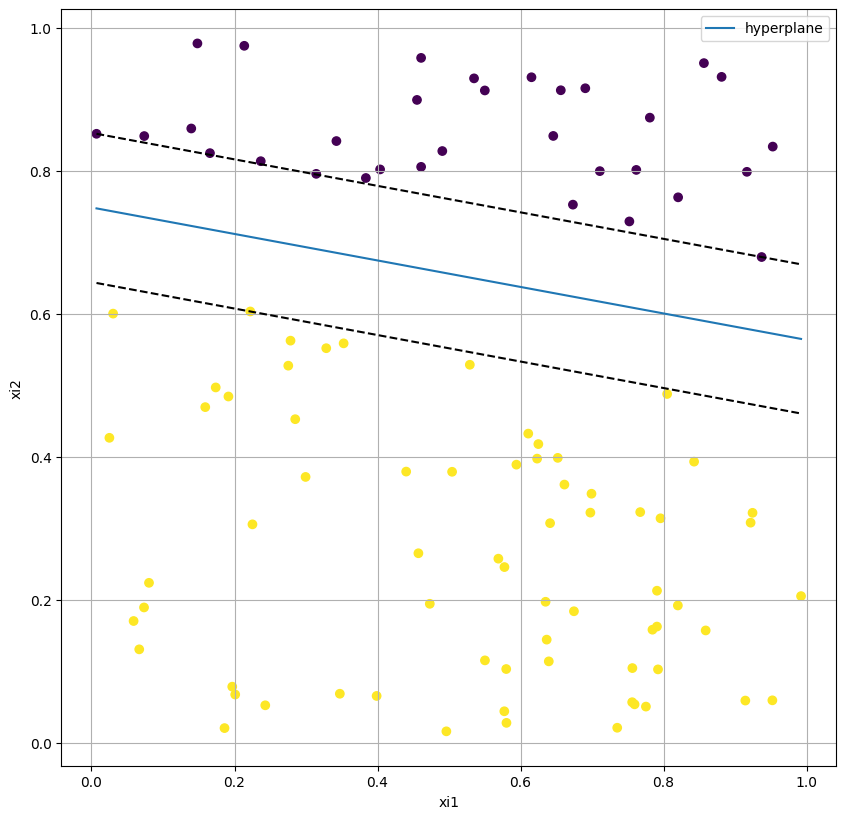

In [12]:
import matplotlib.pyplot as plt
X_data, Y_data = svm.X_data, svm.Y_data
w, b = svm.w, svm.b
fig, ax = plt.subplots(figsize = (10,10))

# plot the original poitns
ax.scatter(X_data[:, 0], X_data[:, 1], c = Y_data)

# plot the hyperplane
x = np.linspace(X_data[:, 0].min(), X_data[:, 0].max())
y = -w[0]/w[1]*x - b/w[1]
ax.plot(x, y, label = "hyperplane")

# plot the margin to each of the class
y = y + 1/w[1]
ax.plot(x, y, linestyle = '--', c='black')
y = y - 2/w[1]
ax.plot(x, y, linestyle = '--', c='black')
ax.legend()
ax.set_xlabel("xi1")
ax.set_ylabel("xi2")
ax.grid()
fig.gca().set_aspect('equal')
fig.show()
